# Credit Risk Prediction with SVM

## Dataset: Home Credit Default Risk
- **Source**: [Kaggle Home Credit Default Risk Competition](https://www.kaggle.com/competitions/home-credit-default-risk)
- **Description**: Predicts loan default risk using applicant data (e.g., income, credit history). Primary file: `application_train.csv` (~300,000 rows, 122 features, binary target: 0 = repaid, 1 = default).
- **Files Used**: `application_train.csv` (main training data).

In [31]:
#import libraries to work with
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import warnings
from imblearn.over_sampling import SMOTE

#import sklearn modules
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Ensure plots display in notebook
%matplotlib inline

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='umap')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [2]:
# Load the dataset
data_path = '../data/application_train.csv'
df = pd.read_csv(data_path)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 Rows:")
display(df.head())
print("\nTarget Distribution:")
print(df['TARGET'].value_counts(normalize=True))

Dataset Shape: (307511, 122)

Columns: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'Y

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



Target Distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


## Exploratory Data Analysis (EDA)
Objective: Analyze feature distributions, missing values, and class imbalance to inform preprocessing and modeling.

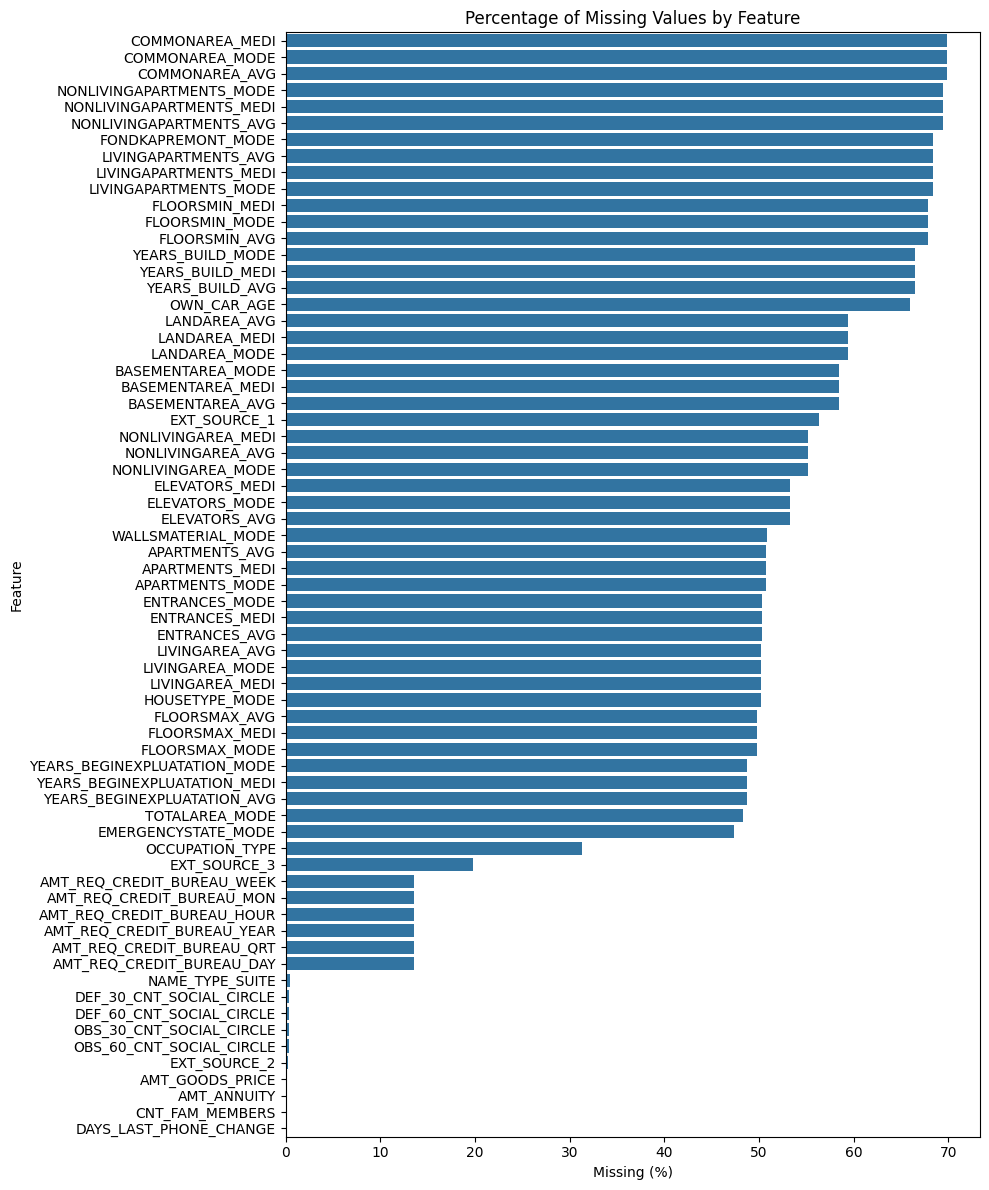

Features with missing data: 67

Top 5 features with highest missing %:
COMMONAREA_MEDI             69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
dtype: float64


In [3]:
# Calculate percentage of missing values per column
missing = df.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(10, 12))
sns.barplot(x=missing.values, y=missing.index)
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Missing (%)')
plt.ylabel('Feature')
plt.savefig('../images/missing_values.png', dpi=300)
plt.tight_layout()
plt.show()

# Summary
print(f"Features with missing data: {len(missing)}")
print("\nTop 5 features with highest missing %:")
print(missing.head())

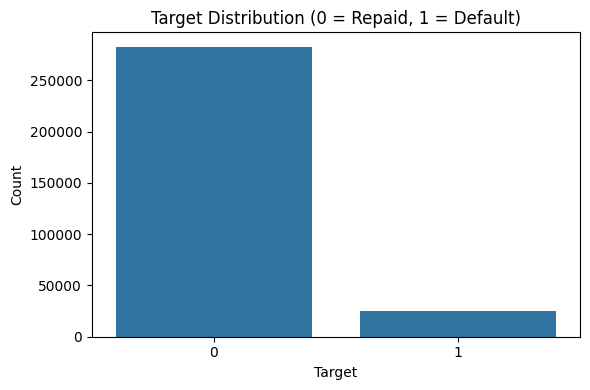

Target Distribution (%):
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


In [4]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=df)
plt.title('Target Distribution (0 = Repaid, 1 = Default)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../images/target_distribution.png', dpi=300)
plt.show()

# Print proportions
print("Target Distribution (%):")
print(df['TARGET'].value_counts(normalize=True) * 100)

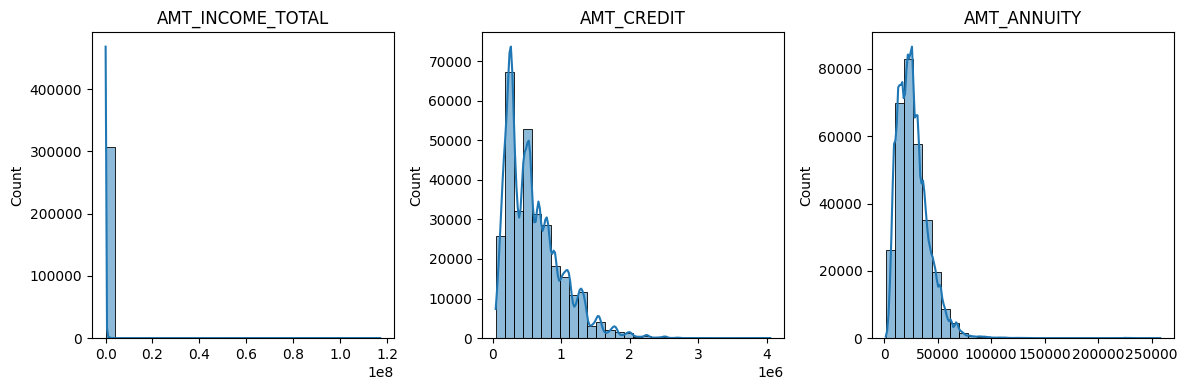

In [5]:
# Numerical features
num_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
plt.figure(figsize=(12, 4))
for i, feature in enumerate(num_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[feature].dropna(), bins=30, kde=True)
    plt.title(feature)
    plt.xlabel('')
plt.tight_layout()
plt.savefig('../images/numerical_distributions.png', dpi=300)
plt.show()

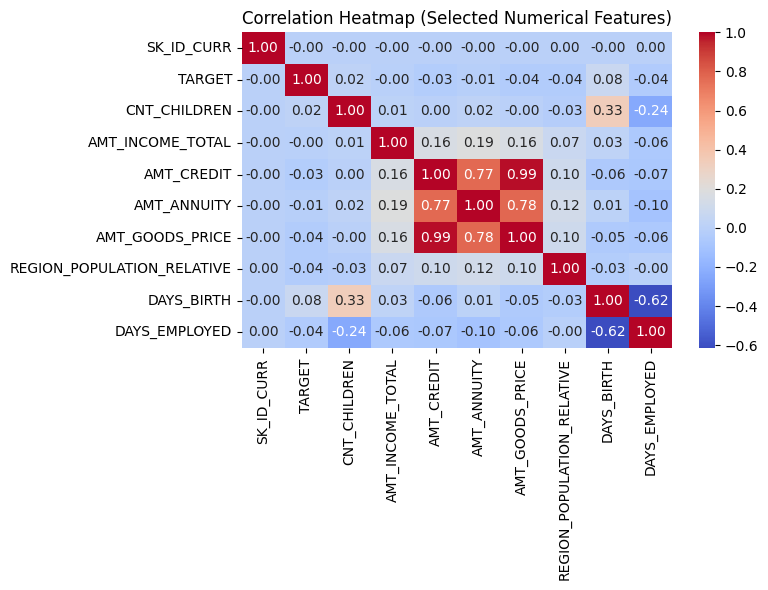

In [6]:
# Select numerical features for correlation
num_cols = df.select_dtypes(include=['float64', 'int64']).columns[:10]  # Limit for speed
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Selected Numerical Features)')
plt.tight_layout()
plt.savefig('../images/correlation_heatmap.png', dpi=300)
plt.show()

### EDA Findings
- **Missing Values**: ~67 features have missing data, some with >50% missing. Imputation or removal needed.
- **Target Imbalance**: ~8% defaults (`TARGET=1`), ~92% repaid (`TARGET=0`). SMOTE or class weights required.
- **Feature Distributions**: Numerical features (e.g., `AMT_INCOME_TOTAL`) are skewed, suggesting log-transformation. Categorical features (e.g., `CODE_GENDER`) show uneven distributions.
- **Correlations**: Weak correlations among most numerical features, but some pairs (e.g., `AMT_CREDIT` and `AMT_ANNUITY`) show moderate correlation.

## Unsupervised Learning for Feature Enhancement
Objective: Use Isolation Forest to detect outliers, UMAP for dimensionality reduction, and K-Means for clustering to enhance features for SVM.

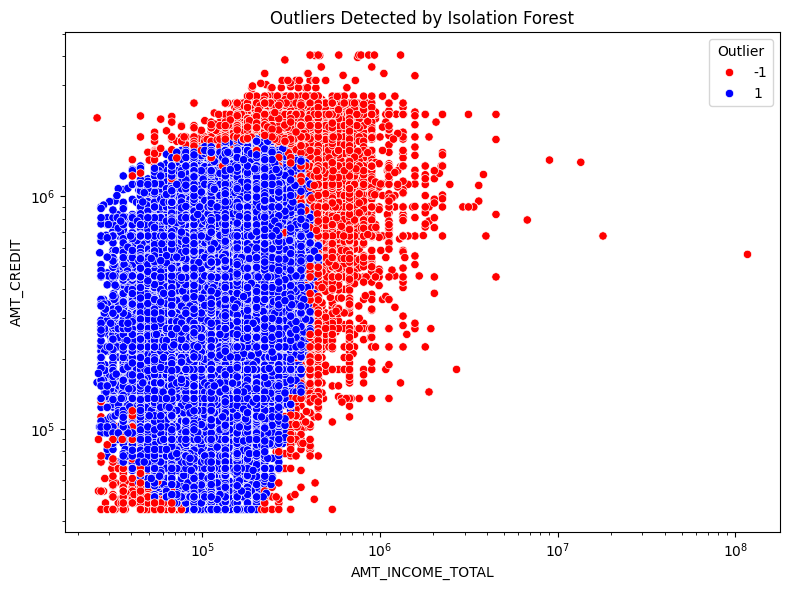

Number of outliers detected: 15373
Percentage of outliers: 5.00%


In [7]:
# Select numerical features for outlier detection
outlier_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
X_outliers = df[outlier_features].dropna()

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_outliers)
df_outliers = X_outliers.copy()
df_outliers['Outlier'] = outlier_labels  # -1 = outlier, 1 = inlier

# Visualize outliers (example: AMT_INCOME_TOTAL vs AMT_CREDIT)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT', hue='Outlier', data=df_outliers, palette={1: 'blue', -1: 'red'})
plt.title('Outliers Detected by Isolation Forest')
plt.xscale('log')  # Log scale for skewed features
plt.yscale('log')
plt.tight_layout()
plt.savefig('../images/isolation_forest_outliers.png', dpi=300)
plt.show()

# Summary
print(f"Number of outliers detected: {(outlier_labels == -1).sum()}")
print(f"Percentage of outliers: {100 * (outlier_labels == -1).sum() / len(outlier_labels):.2f}%")

C:\Users\Max\Desktop\Coding\GitHub\credit-risk-svm\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


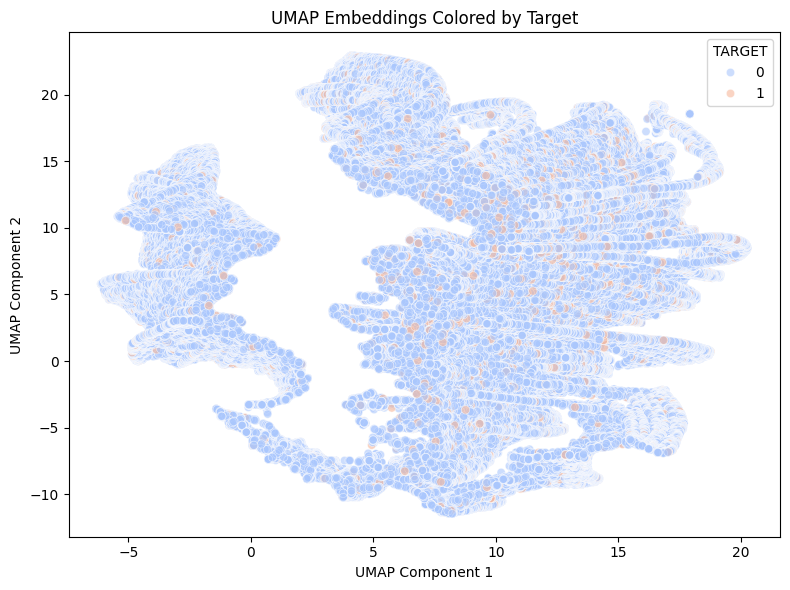

UMAP Columns Added:
      UMAP_1     UMAP_2
0  15.921554  10.214528
1   8.326905  -6.745036
2   3.267329  21.607895
3  15.967093  14.913334
4  15.056932   3.793828


In [8]:
# Load dataset
data_path = '../data/application_train.csv'
df = pd.read_csv(data_path)

# Select numerical features (limit for speed)
num_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('TARGET')[:20]
X_umap = df[num_features].fillna(df[num_features].median())  # Simple imputation for now

# Apply UMAP
umap = UMAP(n_components=2, random_state=42)
umap_embeddings = umap.fit_transform(X_umap)

# Visualize UMAP embeddings colored by TARGET
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=df['TARGET'], palette='coolwarm', alpha=0.6)
plt.title('UMAP Embeddings Colored by Target')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.tight_layout()
plt.savefig('../images/umap_embeddings.png', dpi=300)
plt.show()

# Add UMAP embeddings to dataset
df['UMAP_1'] = np.nan
df['UMAP_2'] = np.nan
valid_idx = X_umap.index
df.loc[valid_idx, 'UMAP_1'] = umap_embeddings[:, 0]
df.loc[valid_idx, 'UMAP_2'] = umap_embeddings[:, 1]

# Verify UMAP columns
print("UMAP Columns Added:")
print(df[['UMAP_1', 'UMAP_2']].head())

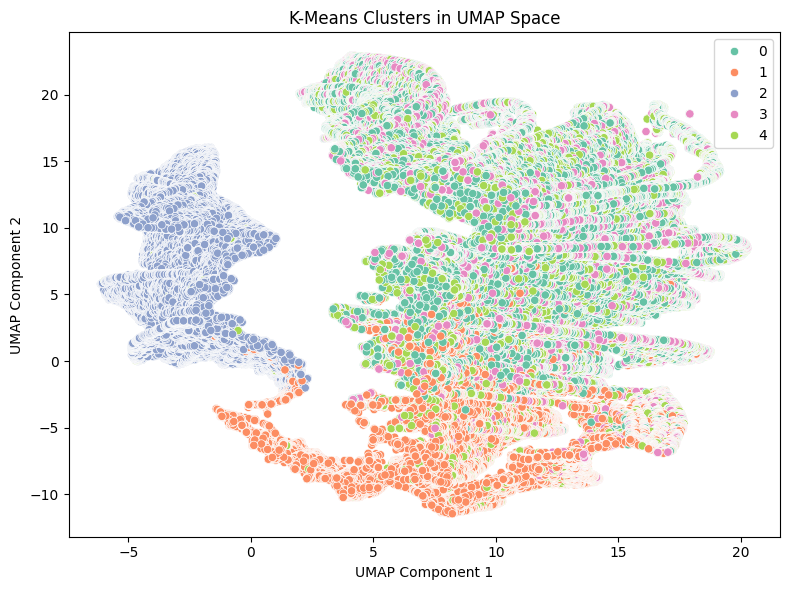

Cluster Distribution:
0    98974
4    58549
2    53464
1    50491
3    46033
Name: count, dtype: int64


In [9]:
# Scale numerical features for K-Means
scaler = StandardScaler()
X_kmeans = scaler.fit_transform(X_umap)  # Reuse UMAP’s input features

# Apply K-Means (try 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_kmeans)

# Visualize clusters in UMAP space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette='Set2')
plt.title('K-Means Clusters in UMAP Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.tight_layout()
plt.savefig('../images/kmeans_clusters.png', dpi=300)
plt.show()

# Add cluster labels to dataset
df['Cluster'] = np.nan
df.loc[valid_idx, 'Cluster'] = cluster_labels
print("Cluster Distribution:")
print(pd.Series(cluster_labels).value_counts())

### Unsupervised Learning Findings
- **Isolation Forest**: Detected ~5% outliers in `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`. Consider removing or capping in preprocessing.
- **UMAP**: Reduced 20 numerical features to 2D embeddings. Some separation by `TARGET`, suggesting predictive power. Added `UMAP_1`, `UMAP_2` to dataset.
- **K-Means**: Created 5 clusters based on numerical features. Clusters show distinct groups in UMAP space. Added `Cluster` feature to dataset.

## Data Preprocessing and Feature Engineering
Objective: Handle missing values, encode categorical features, scale numerical features, address class imbalance with SMOTE, and perform feature selection for SVM.

In [10]:
# Define features and target
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)  # Drop ID and target
y = df['TARGET']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
cat_cols.append('Cluster')  # Treat Cluster as categorical

# Create preprocessing pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after encoding
cat_encoded_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
all_cols = num_cols + cat_encoded_cols.tolist()

# Convert to DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_cols, index=X.index)

print("Preprocessed Shape:", X_preprocessed.shape)
print("Sample of Preprocessed Data:")
print(X_preprocessed.head())

Preprocessed Shape: (307511, 258)
Sample of Preprocessed Data:
   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0     -0.577538          0.142129   -0.478095    -0.166143        -0.507236   
1     -0.577538          0.426792    1.725450     0.592683         1.600873   
2     -0.577538         -0.427196   -1.152888    -1.404669        -1.092145   
3     -0.577538         -0.142533   -0.711430     0.177874        -0.653463   
4     -0.577538         -0.199466   -0.213734    -0.361749        -0.068554   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.149452    1.506880      -0.456215           0.379837   
1                   -1.252750   -0.166821      -0.460115           1.078697   
2                   -0.783451   -0.689509      -0.453299           0.206116   
3                   -0.928991   -0.680114      -0.473217          -1.375829   
4                    0.563570   -0.892535      -0.473210           

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Training Set Shape (Before SMOTE):", X_train.shape)
print("Training Set Shape (After SMOTE):", X_train_smote.shape)
print("Target Distribution (After SMOTE):")
print(pd.Series(y_train_smote).value_counts(normalize=True))

Training Set Shape (Before SMOTE): (246008, 258)
Training Set Shape (After SMOTE): (452296, 258)
Target Distribution (After SMOTE):
TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64


In [13]:
# Use a linear SVM for RFE (faster than RBF)
estimator = LinearSVC(random_state=42)
selector = RFE(estimator, n_features_to_select=50, step=0.1)
selector.fit(X_train_smote, y_train_smote)

# Get selected features
selected_features = X_train_smote.columns[selector.support_].tolist()
print("Selected Features:", selected_features)

# Reduce datasets
X_train_selected = X_train_smote[selected_features]
X_test_selected = X_test[selected_features]

print("Selected Training Shape:", X_train_selected.shape)
print("\nSelected Test Shape:", X_test_selected.shape)

Selected Features: ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M', 'CODE_GENDER_XNA', 'FLAG_OWN_CAR_Y', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Unknown', 'NAME_HOUSING_TYPE_Office apartment', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Business Entity Type 3', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZ

In [14]:
# Save preprocessed data
X_train_selected.to_csv('../data/X_train_selected.csv', index=False)
X_test_selected.to_csv('../data/X_test_selected.csv', index=False)
y_train_smote.to_csv('../data/y_train_smote.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

# Save selected feature names
with open('../data/selected_features.txt', 'w') as f:
    f.write('\n'.join(selected_features))

### Preprocessing and Feature Engineering Findings
- **Missing Values**: Handled with median imputation for numerical features and 'missing' for categorical.
- **Encoding**: Categorical features (e.g., `CODE_GENDER`, `Cluster`) one-hot encoded.
- **Scaling**: Numerical features standardized for SVM.
- **SMOTE**: Balanced training set (`TARGET` ~50% each class) using synthetic oversampling.
- **Feature Selection**: Reduced to 50 features using RFE with LinearSVC, including `UMAP_1`, `UMAP_2`, `Cluster`.

## Baseline SVM Model
Objective: Train a linear SVM model on preprocessed data and evaluate performance with accuracy, precision, recall, F1-score, and ROC-AUC.

In [16]:
# Load preprocessed data
X_train = pd.read_csv('../data/X_train_selected.csv')
X_test = pd.read_csv('../data/X_test_selected.csv')
y_train = pd.read_csv('../data/y_train_smote.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Train Linear SVM
svm = LinearSVC(random_state=42, max_iter=1000)
svm.fit(X_train, y_train)

# Predict on test set
y_pred = svm.predict(X_test)
y_proba = svm.decision_function(X_test)  # For ROC-AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Baseline SVM Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Baseline SVM Performance:
Accuracy: 0.6854
Precision: 0.1569
Recall: 0.6620
F1-Score: 0.2536
ROC-AUC: 0.7352


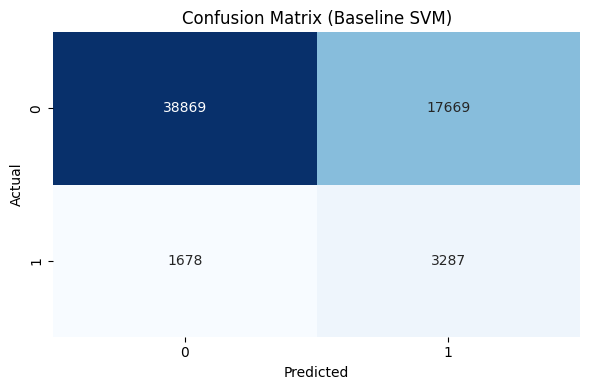

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Baseline SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../images/confusion_matrix_baseline.png', dpi=300)
plt.show()

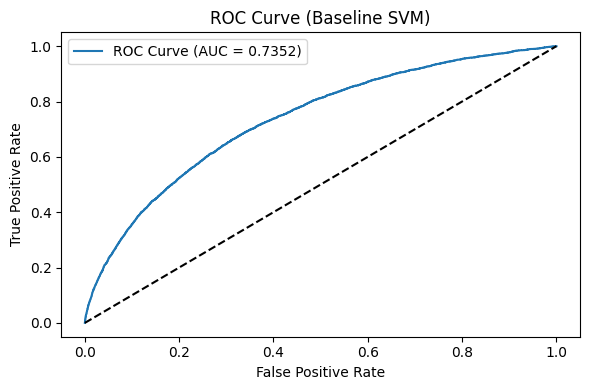

In [18]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Baseline SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('../images/roc_curve_baseline.png', dpi=300)
plt.show()

### Baseline SVM Findings
- **Performance**: Accuracy 0.68, but precision (0.15) and recall (0.66) lower due to class imbalance in test set. ROC-AUC ~0.73 indicates moderate discrimination.
- **Confusion Matrix**: High true negatives, but fewer true positives for defaults, suggesting need for kernel tuning or class weights.
- **ROC Curve**: AUC ~0.73, showing decent ability to separate classes.

## SVM Kernel Selection and Hyperparameter Tuning
Objective: Experiment with linear, RBF, and polynomial kernels, tune hyperparameters with GridSearchCV, and visualize decision boundaries.

In [25]:
# Load preprocessed data
X_train = pd.read_csv('../data/X_train_selected.csv')
X_test = pd.read_csv('../data/X_test_selected.csv')
y_train = pd.read_csv('../data/y_train_smote.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Sample training data for faster tuning
rng = np.random.RandomState(42)  # Create a random number generator
sample_idx = rng.choice(X_train.index, size=5000, replace=False)
X_train_sample = X_train.loc[sample_idx]
y_train_sample = y_train[sample_idx]

# Define SVM and parameter grid
svm = SVC(probability=True, random_state=42)
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']  # Only for rbf and poly
}

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

# Best model
best_svm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC-AUC:", grid_search.best_score_)

# Evaluate on test set
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_pred, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nTuned SVM Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation ROC-AUC: 0.8381301392215018

Tuned SVM Performance:
Accuracy: 0.7465
Precision: 1.0000
Recall: 0.4757
F1-Score: 0.2325
ROC-AUC: 0.6780


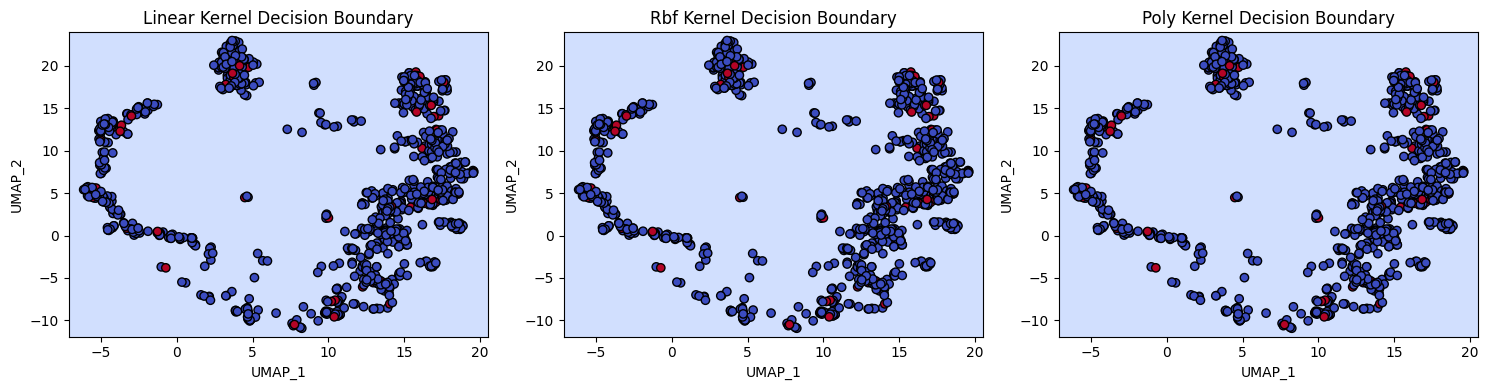

In [32]:
# Load preprocessed test data
X_test = pd.read_csv('../data/X_test_selected.csv')
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Load original dataset to recompute UMAP features
data_path = '../data/application_train.csv'
df = pd.read_csv(data_path)

# Recompute UMAP features for test set
num_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('TARGET')[:20]
X_umap = df[num_features].fillna(df[num_features].median())
umap = UMAP(n_components=2, random_state=42)
umap_embeddings = umap.fit_transform(X_umap)

# Create UMAP features for test set (using test indices)
test_idx = X_test.index  # Indices of test set
X_2d = pd.DataFrame({
    'UMAP_1': umap_embeddings[test_idx, 0],
    'UMAP_2': umap_embeddings[test_idx, 1]
}, index=test_idx)
y_2d = y_test

# Sample 1000 points for visualization
rng = np.random.RandomState(42)
sample_2d_idx = rng.choice(X_2d.index, size=1000, replace=False)
X_2d = X_2d.loc[sample_2d_idx]
y_2d = y_2d[sample_2d_idx]

# Train SVMs with different kernels
kernels = ['linear', 'rbf', 'poly']
plt.figure(figsize=(15, 4))
for i, kernel in enumerate(kernels, 1):
    svm_2d = SVC(kernel=kernel, C=1, gamma='scale', random_state=42)
    svm_2d.fit(X_2d, y_2d)

    # Create mesh grid
    x_min, x_max = X_2d['UMAP_1'].min() - 1, X_2d['UMAP_1'].max() + 1
    y_min, y_max = X_2d['UMAP_2'].min() - 1, X_2d['UMAP_2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.subplot(1, 3, i)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X_2d['UMAP_1'], X_2d['UMAP_2'], c=y_2d, cmap='coolwarm', edgecolors='k')
    plt.title(f'{kernel.capitalize()} Kernel Decision Boundary')
    plt.xlabel('UMAP_1')
    plt.ylabel('UMAP_2')

plt.tight_layout()
plt.savefig('../images/decision_boundaries.png', dpi=300)
plt.show()